# GFI/LFI BAR PLOT AND FEATURE IMPORTANCE SCORE PLOT


In [8]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
sys.path.append('../')
from utils import *
#from utils.feature_selection import *
from plot import *
from simulation_setup import *
from models import *
from models.Extended_IF import *
from models.Extended_DIFFI import *
from models.Extended_DIFFI_original import *
import math
import seaborn as sns
sns.set()

import os
import pickle 
import scipy.io

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Load data from pkl files 

In [ ]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

### Training Set

In [4]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

### Test Set

In [5]:
file_to_read = open(os.getcwd()+'\\anomalies.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d=loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisec'],loaded_dictionary['X_bisec_3d'],loaded_dictionary['X_bisec_6d']

### Bimodal Dataset 

In [10]:
file_to_read = open(os.getcwd()+'\\toy_datasets.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_toy_2d,X_toy_3d,X_toy_4d,X_toy_6d,y = loaded_dictionary['X_toy_2d'],loaded_dictionary['X_toy_3d'],loaded_dictionary['X_toy_4d'],loaded_dictionary['X_toy_6d'],loaded_dictionary['y']

Only the first two features are considered 

In [11]:
X_toy_2d=X_toy_2d[:,:2]
X_toy_2d.shape

(400, 2)

# Plot Functions

These functions can also be found in the Python Script called plot.py

In [12]:
def plt_importances_bars(importances, name, pwd, dim, f = 6):
    
    if 'GFI_' not in name:
        name='LFI_'+name

    
    number_colours = 20
    color = plt.cm.get_cmap('tab20',number_colours).colors
    patterns = [None, "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

    importances_matrix = np.array([np.array(pd.Series(x).sort_values(ascending = False).index).T for x in importances])
    bars = [[(list(importances_matrix[:,j]).count(i)/len(importances_matrix))*100 for i in range(dim)] for j in range(dim)]
    
    bars = pd.DataFrame(bars)
    display(bars)

    tick_names=[]
    for i in range(1,f+1):
        if i==1:
            tick_names.append(r'${}'.format(i) + r'^{st}$')
        elif i==2:
            tick_names.append(r'${}'.format(i) + r'^{nd}$')
        elif i==3:
            tick_names.append(r'${}'.format(i) + r'^{rd}$')
        else:
            tick_names.append(r'${}'.format(i) + r'^{th}$')

    barWidth = 0.85
    r=range(dim)
 
    for i in range(dim):
        plt.bar(r[:f], bars.T.iloc[i,:f].values, bottom=bars.T.iloc[:i,:f].sum().values ,color=color[i%number_colours], edgecolor='white', width=barWidth, label=str(i), hatch=patterns[i//number_colours])


    plt.xlabel("Rank", fontsize = 20)
    #plt.xticks(range(f),[r'$1^{st}$', r'$2^{nd}$', r'$3^{rd}$', r'$4^{th}$', r'$5^{th}$', r'$6^{th}$', r'$7^{th}$', r'$8^{th}$', r'$9^{th}$'][:f])
    plt.xticks(range(f),tick_names[:f])
    plt.ylabel("Percentage count", fontsize = 20)
    plt.yticks(range(10,101,10),[str(x)+"%" for x in range(10,101,10)])
    #plt.title("synthetic {} anomalies E-diffi \n percentage count of feature ranking".format(name,f), fontsize = 18)
    plt.legend(bbox_to_anchor = (1.05,0.95),loc="upper left")
    #plt.savefig(pwd+'/results_local_diffi/images/'+name+'.pdf',bbox_inches = "tight")
    #current_time=datetime.now()
    #tm=[current_time.day,current_time.month,current_time.year,
    #current_time.hour,current_time.minute,current_time.second]
    plt.savefig(pwd+'//results//davide/{}_synt.pdf'
                .format(name),bbox_inches='tight')
    plt.show()

In [13]:
def plt_global_importance_bars(model,X_train,X_test,n_runs,name,pwd,dim,f=6):

    name='GFI_'+name

    #X_test=np.r_[X_train,X_test]

    imps=np.zeros(shape=(n_runs,X_train.shape[1]))
    for i in tqdm(range(n_runs)):
        model.fit(X_train)
        imps[i,:]=model.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)

    #Take the mean feature importance scores over the different runs for the Feature Importance Plot
    #and put it in decreasing order of importance
    mean_imp=np.mean(imps,axis=0)
    std_imp=np.std(imps,axis=0)
    mean_imp_val=np.sort(mean_imp)
    feat_order=mean_imp.argsort()

    plt_data={'Importances': mean_imp_val,
              'feat_order': feat_order,
              'std': std_imp[mean_imp.argsort()]}

    plt_importances_bars(imps,name,pwd,dim,f)
    plt_feat_bar_plot(plt_data,X,name,pwd,f)

In [14]:
def compute_imps(model,X_train,X_test,n_runs,name,pwd,dim,f=6):

    name='GFI_'+name

    #X_test=np.r_[X_train,X_test]

    imps=np.zeros(shape=(n_runs,X_train.shape[1]))
    for i in tqdm(range(n_runs)):
        model.fit(X_train)
        imps[i,:]=model.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)

    path = pwd + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_' + name + '.pkl'
    with open(path, 'wb') as fl:
        pickle.dump(imps,fl)

    #Take the mean feature importance scores over the different runs for the Feature Importance Plot
    #and put it in decreasing order of importance
    mean_imp=np.mean(imps,axis=0)
    std_imp=np.std(imps,axis=0)
    mean_imp_val=np.sort(mean_imp)
    feat_order=mean_imp.argsort()

    plt_data={'Importances': mean_imp_val,
              'feat_order': feat_order,
              'std': std_imp[mean_imp.argsort()]}

    path = pwd + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_' + name + '.pkl'
    with open(path, 'wb') as fl:
        pickle.dump(plt_data,fl)

    return imps,plt_data
    

In [21]:
def plt_feat_bar_plot(global_importances,X,name,pwd,f=6,save=True):
    
    name_file='Feat_bar_plot_'+name 
    patterns = [None, "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

    imp_vals=global_importances['Importances']

    feat_imp=pd.DataFrame({'Global Importance': np.round(imp_vals,3),
                          'Feature': global_importances['feat_order'],
                          'std': global_importances['std']
                          })

    if len(feat_imp)>15:
        feat_imp=feat_imp.iloc[-15:].reset_index(drop=True)
    
    dim=feat_imp.shape[0]

    number_colours = 20

    plt.style.use('default')
    plt.rcParams['axes.facecolor'] = '#F2F2F2'
    plt.rcParams['axes.axisbelow'] = True
    #plt.grid(alpha = 0.7)
    color = plt.cm.get_cmap('tab20',number_colours).colors
    ax1=feat_imp.plot(y='Global Importance',x='Feature',kind="barh",color=color[feat_imp['Feature']%number_colours],xerr='std',
                     capsize=5, alpha=1,legend=False,
                     hatch=[patterns[i//number_colours] for i in feat_imp['Feature']])

    barWidth=0.85

    xlim=np.min(imp_vals)-0.2*np.min(imp_vals)

    text_x=np.max(feat_imp['Global Importance'] + feat_imp['std'])*1.1

    ax1.grid(alpha=0.7)
    ax2 = ax1.twinx()
    # Add labels on the right side of the bars
    values=[]
    for i, v in enumerate(feat_imp['Global Importance']):
        #ax2.text(v + 1, i, str(v) + ' +- ' + str(np.round(feat_imp['std'][i],2)), color='blue', va='center')
        values.append(str(v) + ' +- ' + str(np.round(feat_imp['std'][i],2)))
    
    #print(values)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticks(range(dim))
    ax2.set_yticklabels(values)
    ax2.grid(alpha=0)

    #for i, v in enumerate(feat_imp['Global Importance']):
        #ax.text(text_x,i-0.2,str(v)+' +- ' + str(np.round(feat_imp['std'][i],2)), ha='center', va='bottom')

    plt.axvline(x=0, color=".5")
    ax1.set_xlabel('Importance Score',fontsize=20)
    ax1.set_ylabel('Features',fontsize=20)
    plt.xlim(xlim)
    #plt.yticks(range(dim),feat_imp['Feature'])
    plt.subplots_adjust(left=0.3)
    if save:
        plt.savefig(pwd+'//results//davide/{}.pdf'.format(name_file),bbox_inches='tight')
        
    plt.show()


# AUTOMATIC PLOT FUNCTIONS 

In [15]:
def interpretation_plots(name,pwd):

    os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
    if name=='diabetes' or name=='moodify':
        X,y=csv_dataset(name,os.getcwd()+'\\')
    else:
        X,y=dataset(name,os.getcwd()+'\\')

    X,y=downsample(X,y)
    X_train,X_test=partition_data(X,y)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    X=scaler2.fit_transform(X)
    EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
    dim=X.shape[1]

    # No Split 

    imps,plt_data=compute_imps(EDIFFI,X,X,10,name,pwd,dim,f=6)

    path = pwd + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_GFI_' + name + '.pkl'
    with open(path, 'rb') as fl:
        imps = pickle.load(fl)

    path = pwd + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_GFI_' + name + '.pkl'
    with open(path, 'rb') as fl:
        plt_data = pickle.load(fl)

    plt_importances_bars(imps,name,pwd,dim)
    plt_feat_bar_plot(plt_data,X,name,pwd)
    

    #Split
    name1=name+'_split'
    imps,plt_data=compute_imps(EDIFFI,X_train,X_test,10,name1,pwd,dim)
    plt_importances_bars(imps,name1,pwd,dim)
    plt_feat_bar_plot(plt_data,X,name1,pwd)


breastw 

[numero elementi = 449]
[percentage outliers = 0.5256124721603563]
[number features = 9]
[number outliers = 236]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [09:27<00:00, 56.75s/it]


,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
1,0.0,0.0,0.0,0.0,90.0,0.0,10.0,0.0,0.0
2,0.0,30.0,0.0,20.0,0.0,20.0,20.0,10.0,0.0
3,0.0,0.0,50.0,0.0,10.0,20.0,20.0,0.0,0.0
4,20.0,30.0,20.0,10.0,0.0,0.0,20.0,0.0,0.0
5,20.0,30.0,10.0,0.0,0.0,20.0,0.0,20.0,0.0
6,0.0,0.0,0.0,50.0,0.0,20.0,10.0,20.0,0.0
7,30.0,10.0,10.0,10.0,0.0,20.0,10.0,10.0,0.0
8,30.0,0.0,10.0,10.0,0.0,0.0,10.0,40.0,0.0


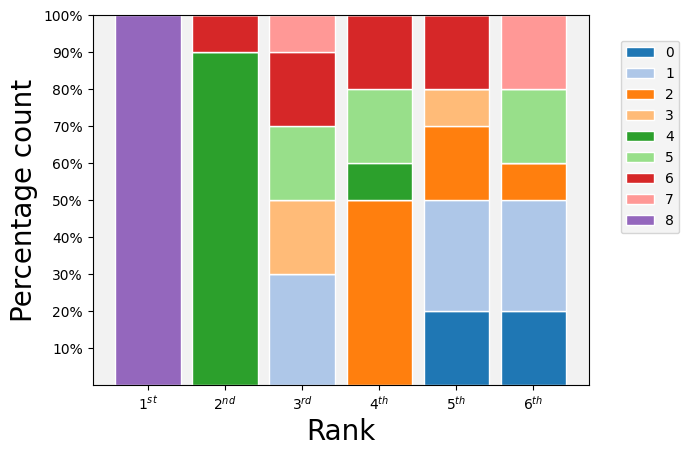

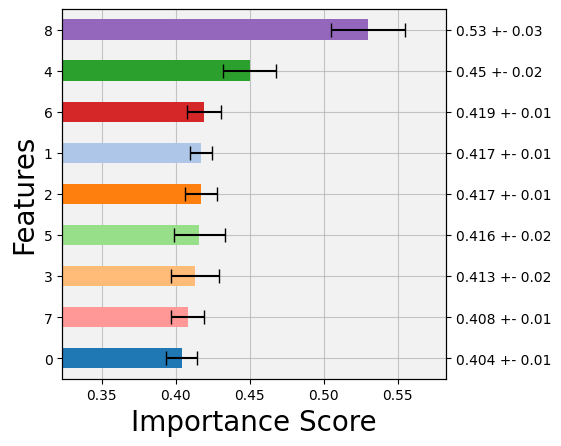

100%|██████████| 10/10 [06:18<00:00, 37.85s/it]


,0,1,2,3,4,5,6,7,8
0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,90.0
1,0.0,0.0,30.0,10.0,10.0,0.0,20.0,20.0,10.0
2,10.0,30.0,0.0,20.0,0.0,0.0,40.0,0.0,0.0
3,10.0,10.0,40.0,20.0,20.0,0.0,0.0,0.0,0.0
4,40.0,0.0,0.0,20.0,10.0,0.0,20.0,10.0,0.0
5,20.0,20.0,10.0,10.0,20.0,0.0,10.0,10.0,0.0
6,10.0,0.0,0.0,0.0,30.0,20.0,10.0,30.0,0.0
7,10.0,20.0,10.0,10.0,10.0,20.0,0.0,20.0,0.0
8,0.0,20.0,0.0,10.0,0.0,60.0,0.0,10.0,0.0


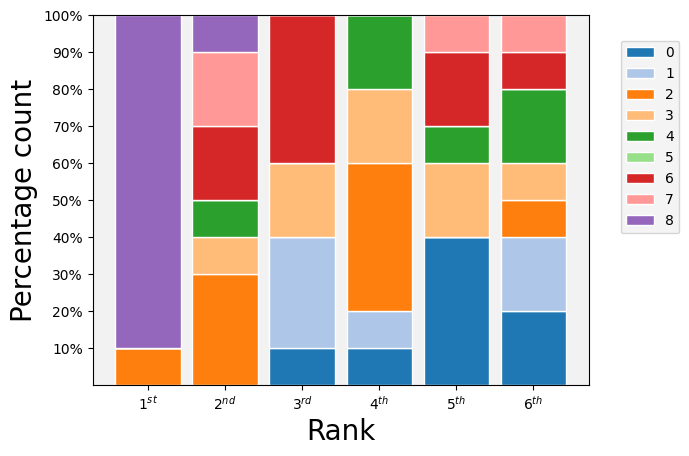

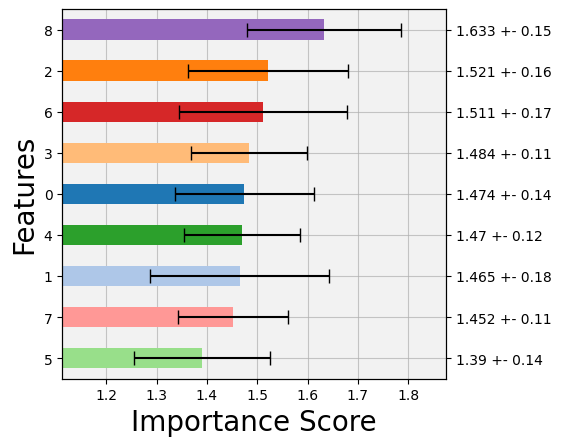

In [9]:
pwd='c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

interpretation_plots('breastw',pwd)

# AUTOMATIC PLOT FUNCTION SYNTHETIC DATASETS

In [16]:
def interpretation_plots_synt(name,X_train,X_test,pwd):

    X=np.r_[X_train,X_test]
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    X=scaler2.fit_transform(X)
    EDIFFI=Extended_DIFFI_original(300,max_depth=100,subsample_size=256,plus=1)
    dim=X.shape[1]

    # No Split 
    imps,plt_data=compute_imps(EDIFFI,X_test,X_test,10,name,pwd,dim,f=6)

    path = pwd + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_GFI_' + name + '.pkl'
    with open(path, 'rb') as fl:
        imps = pickle.load(fl)

    path = pwd + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_GFI_' + name + '.pkl'
    with open(path, 'rb') as fl:
        plt_data = pickle.load(fl)

    plt_importances_bars(imps,name,pwd,dim)
    plt_feat_bar_plot(plt_data,X,name,pwd)

    #Split
    name1=name+'_split'
    imps,plt_data=compute_imps(EDIFFI,X_train,X_test,10,name1,pwd,dim)
    plt_importances_bars(imps,name1,pwd,dim)
    plt_feat_bar_plot(plt_data,X,name1,pwd)


It's important to re load the training set for each different synthetic dataset because, since X_train is shared across all the synthetic data as the training set, otherwise X_train will be scaled multiple times. 

In [12]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [19]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
pwd=os.getcwd()

## Bimodal 

In [ ]:
interpretation_plots_synt('bimodal',X_train,X_test,pwd)

## Xaxis

100%|██████████| 10/10 [18:36<00:00, 111.61s/it]


,0,1,2,3,4,5
0,100.0,0.0,0.0,0.0,0.0,0.0
1,0.0,20.0,30.0,30.0,10.0,10.0
2,0.0,20.0,30.0,20.0,30.0,0.0
3,0.0,40.0,20.0,20.0,10.0,10.0
4,0.0,10.0,10.0,10.0,40.0,30.0
5,0.0,10.0,10.0,20.0,10.0,50.0


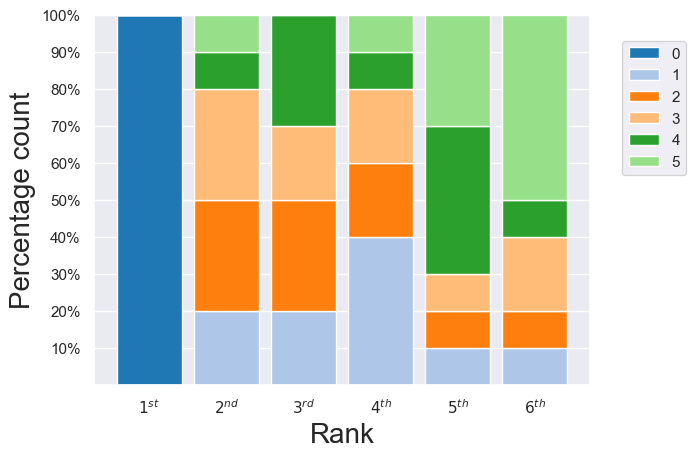

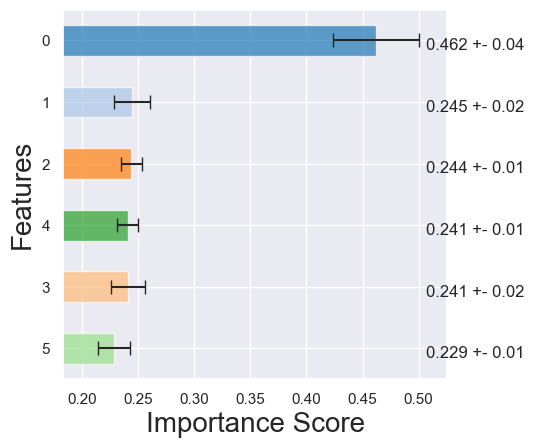

100%|██████████| 10/10 [18:50<00:00, 113.02s/it]


,0,1,2,3,4,5
0,100.0,0.0,0.0,0.0,0.0,0.0
1,0.0,10.0,30.0,20.0,0.0,40.0
2,0.0,10.0,10.0,40.0,30.0,10.0
3,0.0,0.0,20.0,0.0,50.0,30.0
4,0.0,20.0,40.0,10.0,20.0,10.0
5,0.0,60.0,0.0,30.0,0.0,10.0


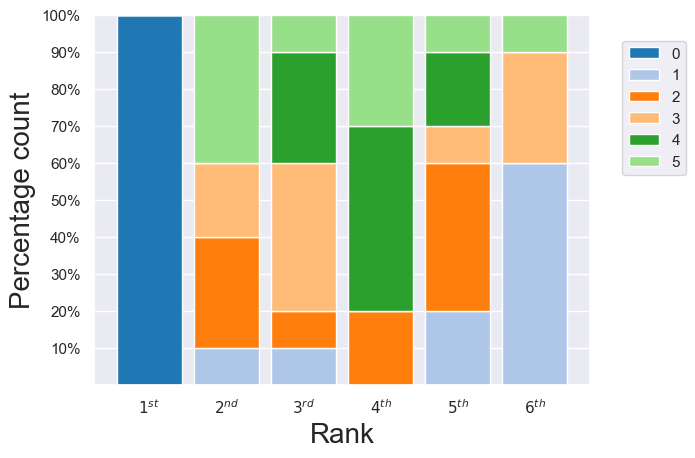

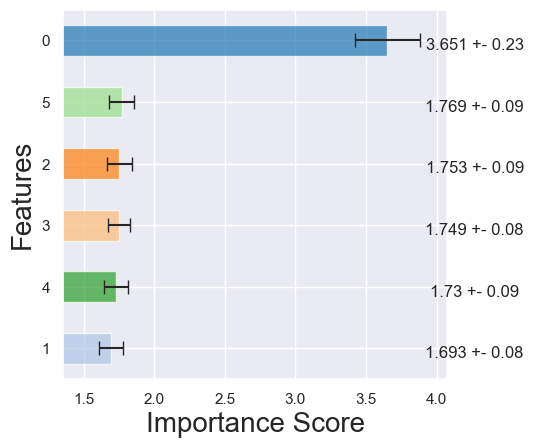

In [21]:
interpretation_plots_synt('Xaxis',X_train,X_xaxis,pwd)

## Yaxis

100%|██████████| 10/10 [17:38<00:00, 105.89s/it]


,0,1,2,3,4,5
0,0.0,100.0,0.0,0.0,0.0,0.0
1,0.0,0.0,30.0,10.0,30.0,30.0
2,20.0,0.0,40.0,10.0,20.0,10.0
3,30.0,0.0,0.0,40.0,10.0,20.0
4,30.0,0.0,20.0,30.0,20.0,0.0
5,20.0,0.0,10.0,10.0,20.0,40.0


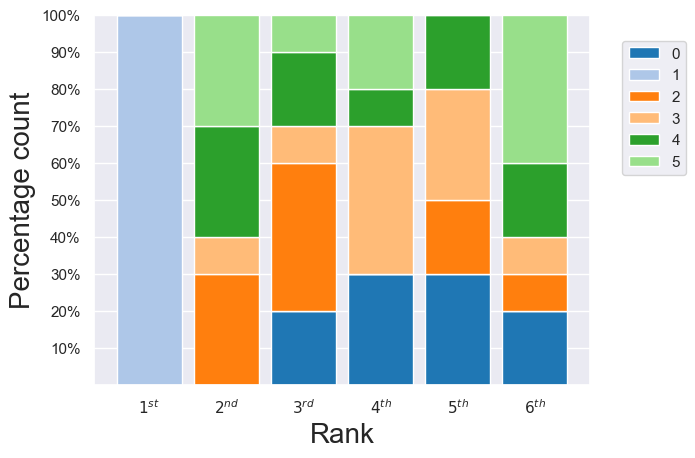

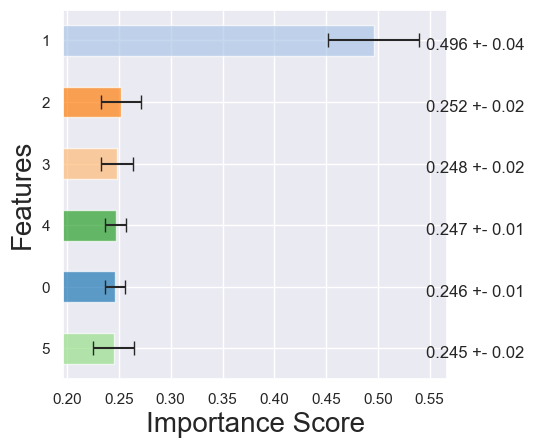

100%|██████████| 10/10 [19:11<00:00, 115.14s/it]


,0,1,2,3,4,5
0,0.0,100.0,0.0,0.0,0.0,0.0
1,40.0,0.0,20.0,20.0,10.0,10.0
2,10.0,0.0,40.0,0.0,20.0,30.0
3,20.0,0.0,10.0,50.0,10.0,10.0
4,10.0,0.0,30.0,10.0,40.0,10.0
5,20.0,0.0,0.0,20.0,20.0,40.0


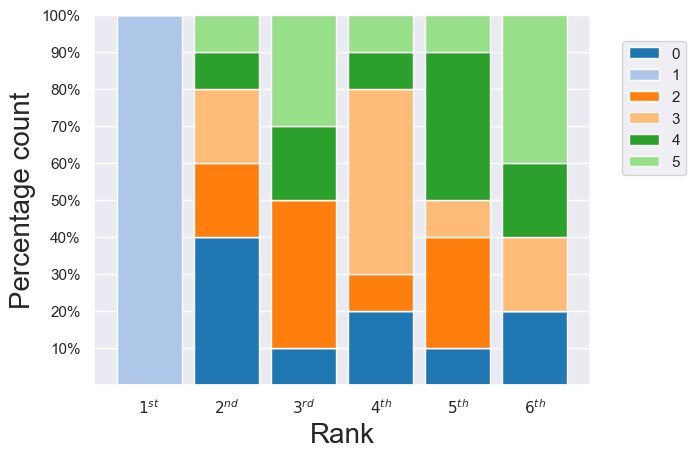

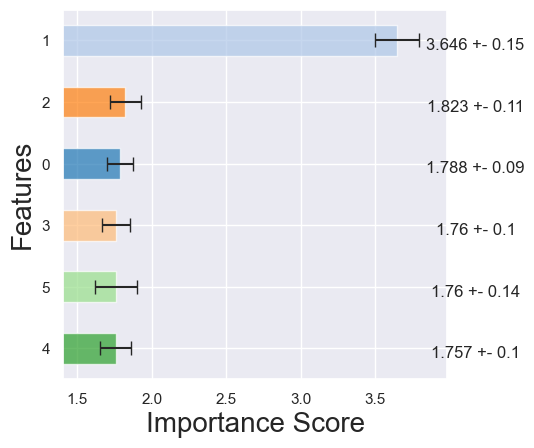

In [22]:
interpretation_plots_synt('Yaxis',X_train,X_yaxis,pwd)

# Bisect

100%|██████████| 10/10 [13:45<00:00, 82.55s/it]


,0,1,2,3,4,5
0,20.0,80.0,0.0,0.0,0.0,0.0
1,80.0,20.0,0.0,0.0,0.0,0.0
2,0.0,0.0,70.0,20.0,10.0,0.0
3,0.0,0.0,20.0,30.0,40.0,10.0
4,0.0,0.0,10.0,20.0,30.0,40.0
5,0.0,0.0,0.0,30.0,20.0,50.0


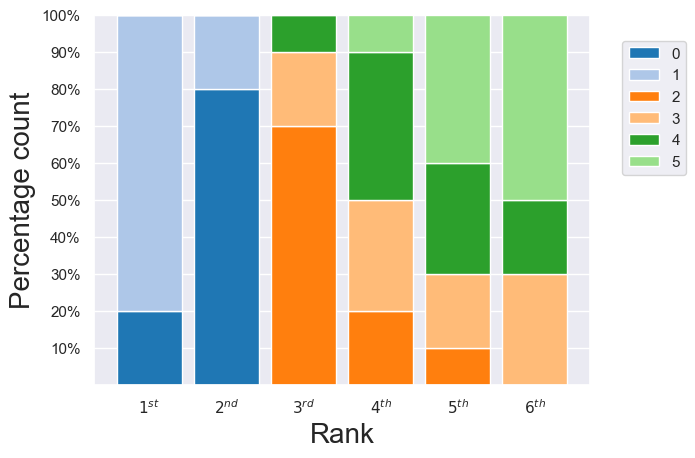

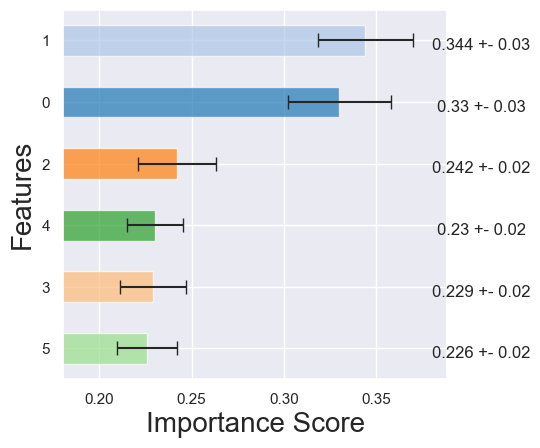

100%|██████████| 10/10 [13:10<00:00, 79.08s/it]


,0,1,2,3,4,5
0,50.0,50.0,0.0,0.0,0.0,0.0
1,50.0,50.0,0.0,0.0,0.0,0.0
2,0.0,0.0,20.0,40.0,20.0,20.0
3,0.0,0.0,30.0,20.0,40.0,10.0
4,0.0,0.0,20.0,30.0,10.0,40.0
5,0.0,0.0,30.0,10.0,30.0,30.0


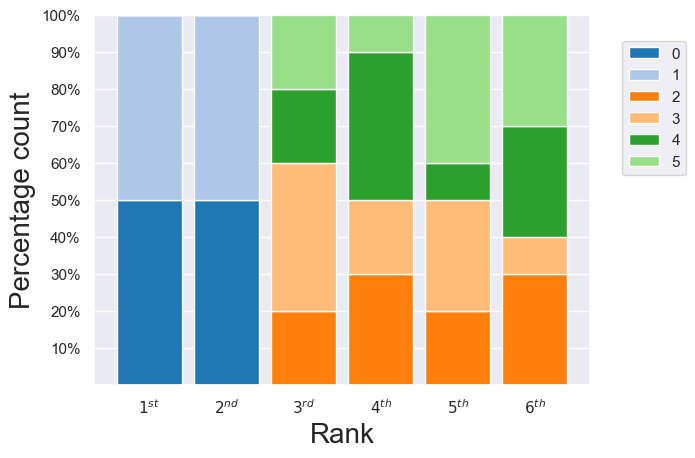

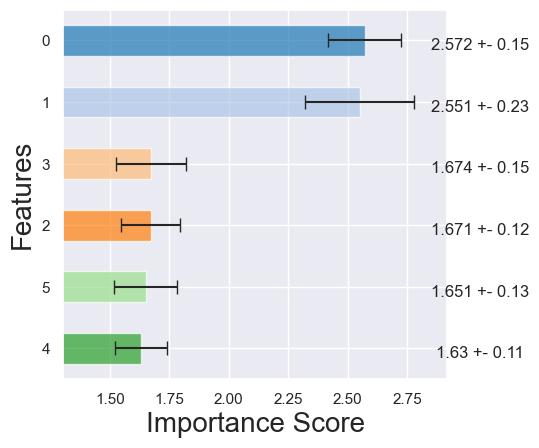

In [14]:
interpretation_plots_synt('Bisect',X_train,X_bisect,pwd)

# Bisect 3d

100%|██████████| 10/10 [16:01<00:00, 96.10s/it] 


,0,1,2,3,4,5
0,20.0,30.0,50.0,0.0,0.0,0.0
1,10.0,50.0,40.0,0.0,0.0,0.0
2,70.0,20.0,10.0,0.0,0.0,0.0
3,0.0,0.0,0.0,40.0,30.0,30.0
4,0.0,0.0,0.0,30.0,50.0,20.0
5,0.0,0.0,0.0,30.0,20.0,50.0


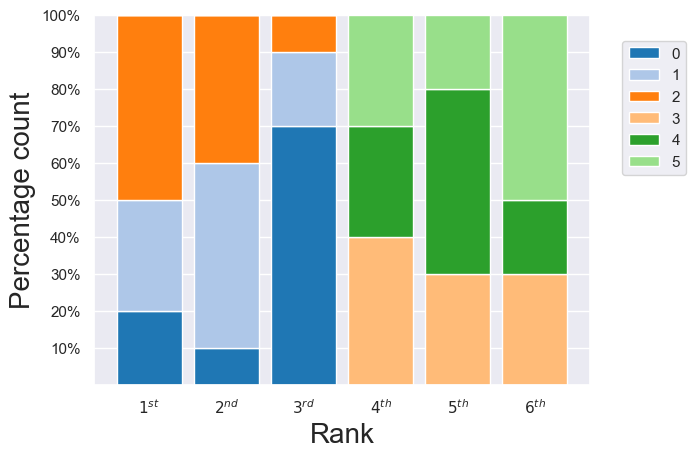

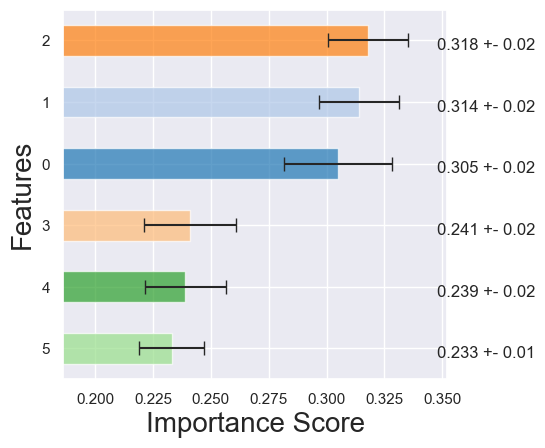

100%|██████████| 10/10 [19:18<00:00, 115.84s/it]


,0,1,2,3,4,5
0,10.0,30.0,60.0,0.0,0.0,0.0
1,40.0,40.0,20.0,0.0,0.0,0.0
2,50.0,30.0,20.0,0.0,0.0,0.0
3,0.0,0.0,0.0,30.0,30.0,40.0
4,0.0,0.0,0.0,10.0,50.0,40.0
5,0.0,0.0,0.0,60.0,20.0,20.0


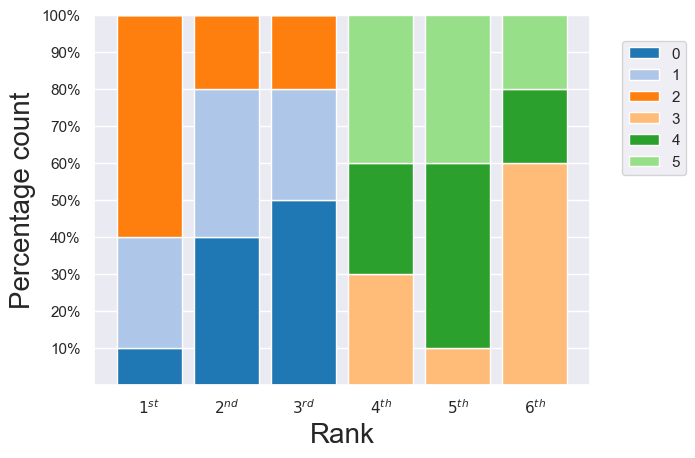

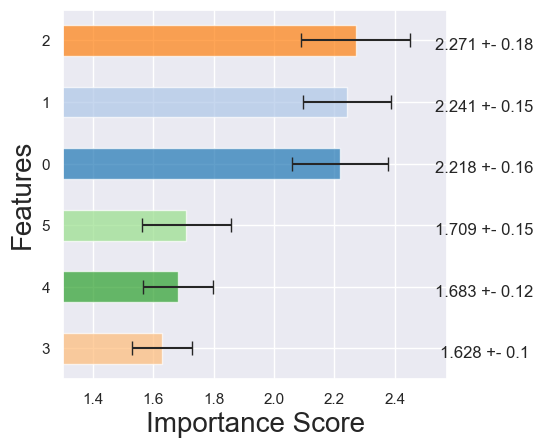

In [15]:
interpretation_plots_synt('Bisect_3d',X_train,X_bisect_3d,pwd)

# Bisect 6d

,0,1,2,3,4,5
0,20.0,20.0,30.0,0.0,20.0,10.0
1,20.0,0.0,30.0,10.0,30.0,10.0
2,40.0,20.0,10.0,10.0,10.0,10.0
3,20.0,20.0,10.0,20.0,20.0,10.0
4,0.0,10.0,10.0,30.0,10.0,40.0
5,0.0,30.0,10.0,30.0,10.0,20.0


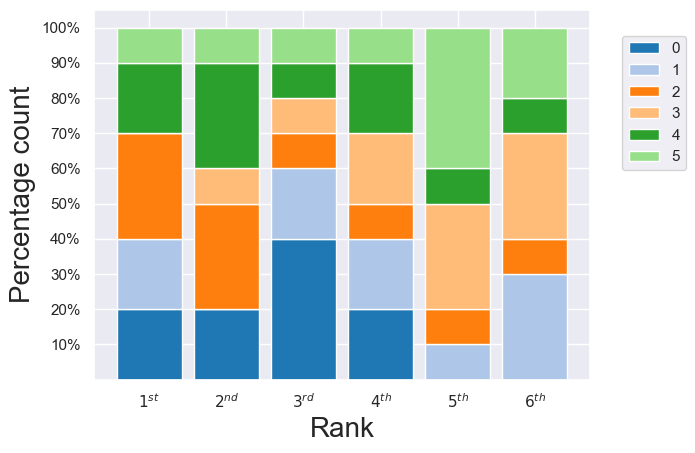

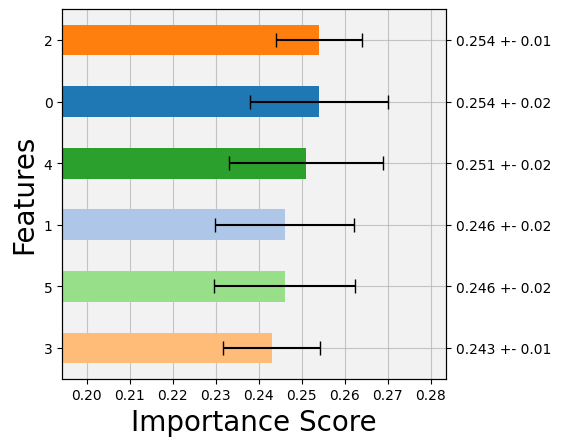

In [17]:
pwd='c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'
name='Bisect_6d'
dim=6
path = pwd + '\\results\\davide\\Importance_Scores\\Imp Score\\imp_score_GFI_' + name + '.pkl'
with open(path, 'rb') as fl:
    imps = pickle.load(fl)

path = pwd + '\\results\\davide\\Importance_Scores\\Plt Data\\plt_data_GFI_' + name + '.pkl'
with open(path, 'rb') as fl:
    plt_data = pickle.load(fl)

plt_importances_bars(imps,name,pwd,dim)
plt_feat_bar_plot(plt_data,X_train,name,pwd)


In [17]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [14:52<00:00, 89.29s/it]


,0,1,2,3,4,5
0,20.0,20.0,30.0,0.0,20.0,10.0
1,20.0,0.0,30.0,10.0,30.0,10.0
2,40.0,20.0,10.0,10.0,10.0,10.0
3,20.0,20.0,10.0,20.0,20.0,10.0
4,0.0,10.0,10.0,30.0,10.0,40.0
5,0.0,30.0,10.0,30.0,10.0,20.0


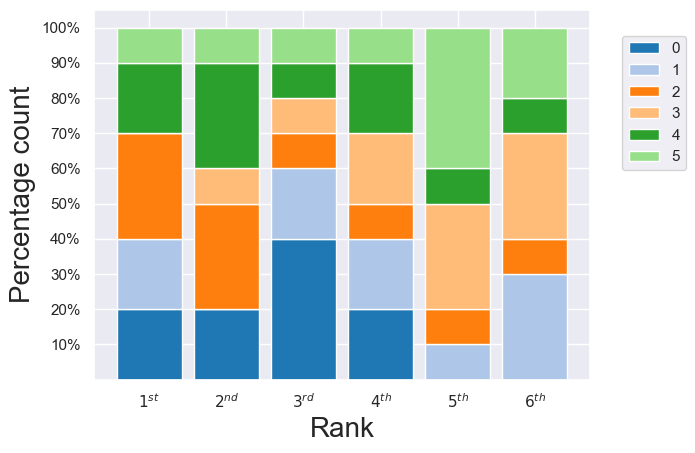

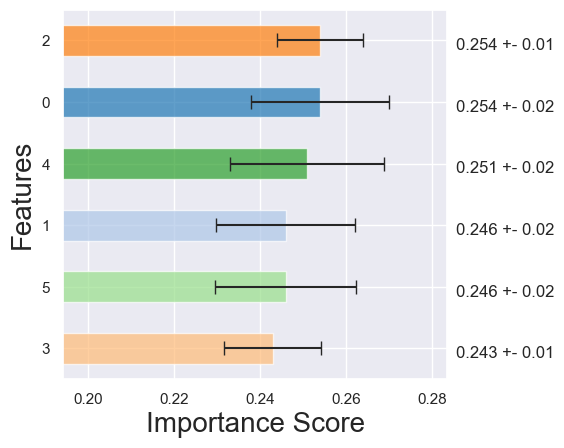

100%|██████████| 10/10 [11:10<00:00, 67.07s/it]


,0,1,2,3,4,5
0,30.0,20.0,10.0,10.0,30.0,0.0
1,20.0,0.0,40.0,30.0,0.0,10.0
2,0.0,20.0,0.0,20.0,50.0,10.0
3,0.0,10.0,40.0,10.0,10.0,30.0
4,40.0,30.0,10.0,10.0,10.0,0.0
5,10.0,20.0,0.0,20.0,0.0,50.0


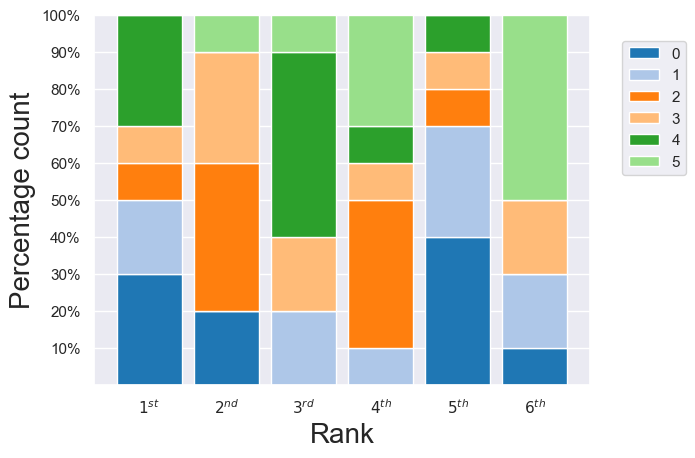

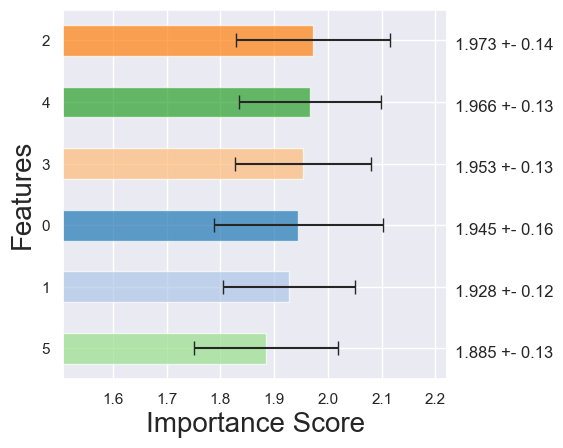

In [18]:
interpretation_plots_synt('Bisect_6d',X_train,X_bisect_6d,pwd)